# Advanced Pandas:  Shaping data  

The second in a series of notebooks that describe Pandas' powerful data management tools.  This one covers shaping methods:  switching rows and columns, pivoting, and stacking.  We'll see that this is all about the indexes:  the row and column labels.  

Outline:  

* [Example:  WEO debt and deficits](#wants).  Something to work with.  
* [Indexing](#index).  Setting and resetting the index.  Multi-indexes. 
* [Switching rows and columns](#pivot).  Transpose.  Referring to variables with multi-indexes.  
* [Stack and unstack](#stack).  Managing column structure and labels.  
* [Pivot](#pivot).  Unstack shortcut if we start with wide data. 
* [Review](#review).  Apply what we've learned.  

More data management topics coming.  

**Note: requires internet access to run.**  

<!-- 
internal links http://sebastianraschka.com/Articles/2014_ipython_internal_links.html
-->

This Jupyter notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://nyu.data-bootcamp.com/).  

## tl;dr

Let `df` be a DataFrame

- We use `df.set_index` to move columns into the index of `df`
- We use `df.reset_index` to move one or more levels of the index back to columns. If we set `drop=True`, the requested index levels are simply thrown away instead of made into columns
- We use `df.stack` to move column index levels into the row index
- We use `df.unstack` to move row index levels into the colunm index (Helpful mnemonic: `unstack` moves index levels **u**p)

<a id=prelims></a>

## Preliminaries 

Import packages, etc  

In [3]:
%matplotlib inline                     

import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 

<a id=wants></a>

## Example:  WEO debt and deficits 

We spend most of our time on one of the examples from the previous notebook. The problem in this example is that variables run across rows, rather than down columns.  Our **want** is to flip some of the rows and columns so that we can plot the data against time.  The question is how.

We use a small subset of the IMF's [World Economic Outlook database](https://www.imf.org/external/ns/cs.aspx?id=28) that contains two variables and three countries.  

In [4]:
url = 'http://www.imf.org/external/pubs/ft/weo/2016/02/weodata/WEOOct2016all.xls'

# (1) define the column indices 
col_indices = [1, 2, 3, 4, 6] + list(range(9, 46))

# (2) download the dataset
weo = pd.read_csv(url, 
                  sep = '\t',
                  #index_col='ISO',
                  usecols=col_indices,
                  skipfooter=1, engine='python',
                  na_values=['n/a', '--'],
                  thousands =',',encoding='windows-1252')

# (3) turn the types of year variables into float 
years = [str(year) for year in range(1980, 2017)]
weo[years] = weo[years].astype(float)

print('Variable dtypes:\n', weo.dtypes, sep='')

Variable dtypes:
ISO                    object
WEO Subject Code       object
Country                object
Subject Descriptor     object
Units                  object
1980                  float64
1981                  float64
1982                  float64
1983                  float64
1984                  float64
1985                  float64
1986                  float64
1987                  float64
1988                  float64
1989                  float64
1990                  float64
1991                  float64
1992                  float64
1993                  float64
1994                  float64
1995                  float64
1996                  float64
1997                  float64
1998                  float64
1999                  float64
2000                  float64
2001                  float64
2002                  float64
2003                  float64
2004                  float64
2005                  float64
2006                  float64
2007                  f

In [5]:
# create debt and deficits dataframe:  two variables and three countries 
variables = ['GGXWDG_NGDP', 'GGXCNL_NGDP']
countries = ['ARG', 'DEU', 'GRC']
dd = weo[weo['WEO Subject Code'].isin(variables) & weo['ISO'].isin(countries)]

In [6]:
# change column labels to something more intuitive 
dd = dd.rename(columns={'WEO Subject Code': 'Variable', 
                        'Subject Descriptor': 'Description'})

In [7]:
# rename variables (i.e. values of observables)
dd['Variable'] = dd['Variable'].replace(to_replace=['GGXWDG_NGDP', 'GGXCNL_NGDP'], value=['Debt', 'Surplus'])
dd

,ISO,Variable,Country,Description,Units,1980,1981,1982,1983,1984,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
252,ARG,Surplus,Argentina,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
260,ARG,Debt,Argentina,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
2716,DEU,Surplus,Germany,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
2724,DEU,Debt,Germany,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
2804,GRC,Surplus,Greece,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
2812,GRC,Debt,Greece,General government gross debt,Percent of GDP,22.526,26.681,29.310,33.591,40.061,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


### Reminders

What kind of object does each of the following produce?  

In [8]:
dd.index

Int64Index([252, 260, 2716, 2724, 2804, 2812], dtype='int64')

In [9]:
dd.columns

Index(['ISO', 'Variable', 'Country', 'Description', 'Units', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
       '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype='object')

In [10]:
dd['ISO']

252     ARG
260     ARG
2716    DEU
2724    DEU
2804    GRC
2812    GRC
Name: ISO, dtype: object

In [11]:
dd[['ISO', 'Variable']]

,ISO,Variable
252,ARG,Surplus
260,ARG,Debt
2716,DEU,Surplus
2724,DEU,Debt
2804,GRC,Surplus
2812,GRC,Debt


In [12]:
dd[dd['ISO'] == 'ARG']

,ISO,Variable,Country,Description,Units,1980,1981,1982,1983,1984,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
252,ARG,Surplus,Argentina,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
260,ARG,Debt,Argentina,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751


### Wants 

We might imagine doing several different things with this data:

* Plot a specific variable (debt or surplus) for a given date. 
* Time series plots for a specific country.
* Time series plots for a specific variable.  

Depending on which we want, we might organize the data differently.  We'll focus on the last two.  

Here's a brute force approach to the problem:  simply transpose the data.  This is where that leads:  

In [13]:
dd.T

,252,260,2716,2724,2804,2812
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
1980,NaN,NaN,NaN,NaN,-2.774,22.526
1981,NaN,NaN,NaN,NaN,-7.847,26.681
1982,NaN,NaN,NaN,NaN,-6.092,29.31
1983,NaN,NaN,NaN,NaN,-6.847,33.591
1984,NaN,NaN,NaN,NaN,-7.976,40.061


**Comments.** The problem here is that the columns include both the numbers (which we want to plot) and some descriptive information (which we don't).  

<a id='index'></a>

## Setting and resetting the index

We start by setting and resetting the index.  That may sound like a step backwards -- haven't we done this already? -- but it reminds us of some things that will be handy later.  

Take the dataframe `dd`.  What would we like in the index?  Evenutally we'd like the dates llke `[2011, 2012, 2013]`, but right now the row labels are more naturally the variable or country.  Here are some varriants.  

### Setting the index

In [14]:
dd.set_index('Country')

,ISO,Variable,Description,Units,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,ARG,Surplus,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Argentina,ARG,Debt,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
Germany,DEU,Surplus,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
Germany,DEU,Debt,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
Greece,GRC,Surplus,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,-10.603,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
Greece,GRC,Debt,General government gross debt,Percent of GDP,22.526,26.681,29.310,33.591,40.061,46.621,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


In [15]:
# we can do the same thing with a list, which will be meaningful soon...
dd.set_index(['Country'])

,ISO,Variable,Description,Units,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,ARG,Surplus,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Argentina,ARG,Debt,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
Germany,DEU,Surplus,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
Germany,DEU,Debt,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
Greece,GRC,Surplus,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,-10.603,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
Greece,GRC,Debt,General government gross debt,Percent of GDP,22.526,26.681,29.310,33.591,40.061,46.621,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


**Exercise.** Set `Variable` as the index.  

**Comment.** Note that the new index brought its **name** along:  `Country` in the two examples, `Variable` in the exercise.  That's incredibly useful because we can refer to index levels by name.  If we happen to have an index without a name, we can set it with 

```python
df.index.name = 'Whatever name we like'
```

### Multi-indexes

We can put more than one variable in an index, which gives us a **multi-index**.  This is sometimes called a **hierarchical index** because the **levels** of the index (as they're called) are ordered. 

Multi-indexes are more common than you might think.  One reason is that data itself is often multi-dimensional.  A typical spreadsheet has two dimensions:  the variable and the observation.  The WEO data is naturally three dimensional:  the variable, the year, and the country.  (Think about that for a minute, it's deeper than it sounds.) 

The problem we're having is fitting this nicely into two dimensions.  A multi-index allows us to manage that.  A two-dimensional index would work here -- the country and the variable code -- but right now we have some redundancy.  

**Example.** We push all the descriptive, non-numerical columns into the index, leaving the dataframe itself with only numbers, which seems like a step in thee right direction.  

In [16]:
ddi = dd.set_index(['Variable', 'Country', 'ISO', 'Description', 'Units'])
ddi

,,,,,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,Country,ISO,Description,Units,,,,,,,,,,,,,,,,,,,,,
Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,Argentina,ARG,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
Debt,Germany,DEU,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,-10.603,-9.559,-8.972,-10.675,-13.195,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
Debt,Greece,GRC,General government gross debt,Percent of GDP,22.526,26.681,29.310,33.591,40.061,46.621,47.142,52.413,57.069,59.821,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


Let's take a closer look at the index

In [17]:
ddi.index

MultiIndex(levels=[['Debt', 'Surplus'], ['Argentina', 'Germany', 'Greece'], ['ARG', 'DEU', 'GRC'], ['General government gross debt', 'General government net lending/borrowing'], ['Percent of GDP']],
           labels=[[1, 0, 1, 0, 1, 0], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0]],
           names=['Variable', 'Country', 'ISO', 'Description', 'Units'])

That's a lot to process, so we break it into pieces.  

* `ddi.index.names` contains a list of level names.  (Remind yourself that lists are ordered, so this tracks levels.)
* `ddi.index.levels` contains the values in each level.  

Here's what they like like here:  

In [18]:
# Chase and Spencer like double quotes 
print("The level names are:\n", ddi.index.names, "\n", sep="")
print("The levels (aka level values) are:\n", ddi.index.levels, sep="")

The level names are:
['Variable', 'Country', 'ISO', 'Description', 'Units']

The levels (aka level values) are:
[['Debt', 'Surplus'], ['Argentina', 'Germany', 'Greece'], ['ARG', 'DEU', 'GRC'], ['General government gross debt', 'General government net lending/borrowing'], ['Percent of GDP']]


Knowing the order of the index components and being able to inspect their values and names is fundamental to working with a multi-index.

**Exercise**: What would happen if we had switched the order of the strings in the list when we called `dd.set_index`? Try it with this list to find out: `['ISO', 'Country', 'Variable', 'Description', 'Units']`

### Resetting the index

We've seen that `set_index` pushes columns into the index.  Here we see that `reset_index` does the reverse:  it pushes components of the index back to the columns.  

**Example.** 

In [19]:
ddi.head(2)

,,,,,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,Country,ISO,Description,Units,,,,,,,,,,,,,,,,,,,,,
Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,Argentina,ARG,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751


In [20]:
ddi.reset_index()

,Variable,Country,ISO,Description,Units,1980,1981,1982,1983,1984,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
1,Debt,Argentina,ARG,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
2,Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
3,Debt,Germany,DEU,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
4,Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
5,Debt,Greece,GRC,General government gross debt,Percent of GDP,22.526,26.681,29.310,33.591,40.061,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


In [21]:
# or we can reset the index by level 
ddi.reset_index(level=1).head(2) 

,,,,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,ISO,Description,Units,,,,,,,,,,,,,,,,,,,,,
Surplus,ARG,General government net lending/borrowing,Percent of GDP,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,ARG,General government gross debt,Percent of GDP,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751


In [22]:
# or by name 
ddi.reset_index(level='Units').head(2) 

,,,,Units,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,Country,ISO,Description,,,,,,,,,,,,,,,,,,,,,
Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,Argentina,ARG,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751


In [23]:
# or do more than one at a time
ddi.reset_index(level=[1, 3]).head(2)

,,,Country,Description,1980,1981,1982,1983,1984,1985,1986,1987,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,ISO,Units,,,,,,,,,,,,,,,,,,,,,
Surplus,ARG,Percent of GDP,Argentina,General government net lending/borrowing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,ARG,Percent of GDP,Argentina,General government gross debt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751


**Comment.** By default, `reset_index` pushes one or more index levels into columns.  If we want to discard that level of the index altogether, we use the parameter `drop=True`.  

In [24]:
ddi.reset_index(level=[1, 3], drop=True).head(2) 

,,,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,ISO,Units,,,,,,,,,,,,,,,,,,,,,
Surplus,ARG,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,ARG,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751


**Exercise.**  For the dataframe `ddi` do the following in separate code cells:  

* Use the `reset_index` method to move the `Units` level of the index to a column of the dataframe.
* Use the `drop` parameter of `reset_index` to delete `Units` from the dataframe.  

## Switching rows and columns   

If we take the dataframe `ddi`, we see that the everything's been put into the index but the data itself.  Perhaps we can get what we want if we just flip the rows and columns.  Roughly speaking, we refer to this as **pivoting**.  

### First look at switching rows and columns 

The simplest way to flip rows and columns is to use the `T` or transpose property.  When we do that, we end up with a lot of stuff in the column labels, as the multi-index for the rows gets rotated into the columns.  Other than that, we're good. We can even do a plot.  The only problem is all the stuff we've pushed into the column labels -- it's kind of a mess.  

In [25]:
ddt = ddi.T
ddt

Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
1980,NaN,NaN,NaN,NaN,-2.774,22.526
1981,NaN,NaN,NaN,NaN,-7.847,26.681
1982,NaN,NaN,NaN,NaN,-6.092,29.310
1983,NaN,NaN,NaN,NaN,-6.847,33.591
1984,NaN,NaN,NaN,NaN,-7.976,40.061
1985,NaN,NaN,NaN,NaN,-10.603,46.621


**Comment.** We see here that the multi-index for the rows has been turned into a multi-index for the columns.  Works the same way.  

The only problem here is that the column labels are more complicated than we might want.  Here, for example, is what we get with the plot method.  As usual, `.plot()` plots all the columns of the dataframe, but here that means we're mixing variables.  And the legend contains all the levels of the column labels.  

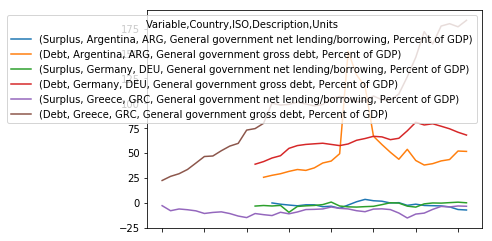

In [26]:
ddt.plot()

### Referring to variables with a multi-index

Can we refer to variables in the same way?  Sort of, as long as we refer to the top level of the column index.  It gives us a dataframe that's a subset of the original one.  

Let's try each of these:  

* `ddt['Debt']`
* `ddt['Debt']['Argentina']`
* `ddt['Debt', 'Argentina']` 
* `ddt['ARG']`

What do you see? 

In [27]:
# indexing by variable 
debt = ddt['Debt']
debt

Country,Argentina,Germany,Greece
ISO,ARG,DEU,GRC
Description,General government gross debt,General government gross debt,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP
1980,NaN,NaN,22.526
1981,NaN,NaN,26.681
1982,NaN,NaN,29.310
1983,NaN,NaN,33.591
1984,NaN,NaN,40.061
1985,NaN,NaN,46.621
1986,NaN,NaN,47.142


In [28]:
ddt['Debt']['Argentina']

ISO,ARG
Description,General government gross debt
Units,Percent of GDP
1980,NaN
1981,NaN
1982,NaN
1983,NaN
1984,NaN
1985,NaN
1986,NaN
1987,NaN


In [29]:
ddt['Debt', 'Argentina']

/Users/wasserman/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


ISO,ARG
Description,General government gross debt
Units,Percent of GDP
1980,NaN
1981,NaN
1982,NaN
1983,NaN
1984,NaN
1985,NaN
1986,NaN
1987,NaN


In [30]:
#ddt['ARG']

What's going on?  The theme is that we can reference the top level, which in `ddi` is the `Variable`.  If we try to access a lower level, it bombs.  

**Exercise.** With the dataframe `ddt`: 

* What type of object is `ddt["Debt"]`? 

* Construct a line plot of `Debt` over time with one line for each country.  

SOL

<!--
ddt['Debt'].dtypes
-->

SOL

<!--
ddt['Debt'].plot()
-->

**Example.** Let's do this together.  How would we fix up the legend?  What approaches cross your mind?  (No code, just the general approach.) 

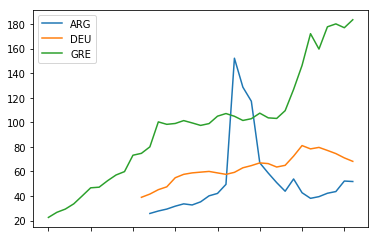

In [31]:
fig, ax = plt.subplots()
ddt['Debt'].plot(ax=ax)
ax.legend(['ARG', 'DEU', 'GRE'], loc='best')
#ax.axhline(100, color='k', linestyle='--', alpha=.5)

### Swapping levels

Since variables refer to the first level of the column index, it's not clear how we would group data by country.  Suppose, for example, we wanted to plot `Debt` and `Surplus` for a specific country.  What would we do?  

One way to do that is to make the country the top level with the `swaplevel` method.  Note the `axis` parameter.  With `axis=1` we swap column levels, with `axis=0` (the default) we swap row levels.  

In [32]:
ddts = ddt.swaplevel(0, 1, axis=1) 
ddts

Country                                    Argentina  \
Variable                                     Surplus   
ISO                                              ARG   
Description General government net lending/borrowing   
Units                                 Percent of GDP   
1980                                             NaN   
1981                                             NaN   
1982                                             NaN   
1983                                             NaN   
1984                                             NaN   
1985                                             NaN   
1986                                             NaN   
1987                                             NaN   
1988                                             NaN   
1989                                             NaN   
1990                                             NaN   
1991                                             NaN   
1992                                             NaN   
1993                                          -0.025   
1994                                          -1.289   
1995                                          -2.137   
1996                                          -2.898   
1997                                          -1.890   
1998                                          -1.882   
1999                                          -3.813   
2000                                          -3.326   
2001                                          -5.424   
2002                                          -2.123   
2003                                           1.173   
2004                                           3.549   
2005                                           2.187   
2006                                           1.709   
2007                                          -0.056   
2008                                           0.242   
2009                                          -2.434   
2010                                          -1.272   
2011                                          -2.552   
2012                                          -2.802   
2013                                          -3.001   
2014                                          -3.990   
2015                                          -6.630   
2016                                          -7.123   

Country                                    \
Variable                             Debt   
ISO                                   ARG   
Description General government gross debt   
Units                      Percent of GDP   
1980                                  NaN   
1981                                  NaN   
1982                                  NaN   
1983                                  NaN   
1984                                  NaN   
1985                                  NaN   
1986                                  NaN   
1987                                  NaN   
1988                                  NaN   
1989                                  NaN   
1990                                  NaN   
1991                                  NaN   
1992                               25.746   
1993                               27.739   
1994                               29.310   
1995                               31.673   
1996                               33.561   
1997                               32.662   
1998                               35.200   
1999                               40.097   
2000                               42.060   
2001                               49.436   
2002                              152.112   
2003                              128.561   
2004                              117.116   
2005                               66.938   
2006                               58.622   
2007                               50.842   
2008                               43.853   
2009                               53.828   
2010                               42.624   
2011                       

**Exercise.** Use the dataframe `ddts` to plot `Debt` and `Surplus` across time for Argentina.  *Hint:* In the `plot` method, set `subplots=True` so that each variable is in a separate subplot.  

SOL

<!--
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ddts['Argentina']['Surplus'].plot(ax=ax[0])
ax[0].legend(['Surplus'])
ddts['Argentina']['Debt'].plot(ax=ax[1])
ax[1].legend(['Debt'])

ax[0].axhline(0, color='k')
ax[0].set_ylim([-10, 10])
-->

### The `xs` method

Another approach to extracting data that cuts across levels of the row or column index:  the `xs` method. This is recent addition to Pandas and an extremely good method once you get the hang of it. 

The basic syntax is 
```python
df.xs(item, axis=X, level=N)
```

where `N` is the name or number of an index level and `X` describes if we are extracting from the index or column names. Setting `X=0` (so `axis=0`) will slice up the data along the index, `X=1` extracts data for column labels.

Here's how we could use `xs` to get the Argentina data without swapping the level of the column labels

In [33]:
# ddt.xs?

In [34]:
ddt.xs("Argentina", axis=1, level="Country")

Variable,Surplus,Debt
ISO,ARG,ARG
Description,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP
1980,NaN,NaN
1981,NaN,NaN
1982,NaN,NaN
1983,NaN,NaN
1984,NaN,NaN
1985,NaN,NaN
1986,NaN,NaN


In [35]:
ddt.xs("Argentina", axis=1, level="Country")["Debt"]

ISO,ARG
Description,General government gross debt
Units,Percent of GDP
1980,NaN
1981,NaN
1982,NaN
1983,NaN
1984,NaN
1985,NaN
1986,NaN
1987,NaN


**Exercise.** Use a combination of `xs` and standard slicing with `[...]` to extract the variable `Debt` for Greece.

SOL

<!--
ddt.xs("Greece", axis=1, level="Country")["Debt"]
-->

**Exercise.** Use the dataframe `ddt` -- and the `xs` method -- to plot `Debt` and `Surplus` across time for Argentina.  

SOL

<!--
fig, ax = plt.subplots()
ddt.xs('Argentina', axis=1, level='Country').plot(ax=ax)
ax.legend(['Surplus', 'Debt'])
-->

<a id='stack'></a>

## Stacking and unstacking 

The `set_index` and `reset_index` methods work on the row labels -- the index.  They move columns to the index and the reverse.  The `stack` and `unstack` methods move index levels to and from column levels:  

* `stack` moves the "inner most" (closest to the data when printed) column label into a row label. This creates a **long** dataframe. 
* `unstack` does the reverse, it moves the inner most level of the index `u`p to become the inner most column label. This creates a **wide** dataframe.  


We use both to shape (or reshape) our data.  We use `set_index` to push things into the index.  And then use `reset_index` to push some of them back to the columns.  That gives us pretty fine-grainded control over the shape of our data. Intuitively

- stacking (vertically): wide table $\rightarrow$ long table
- unstacking: long table $\rightarrow$ wide table

In [36]:
ddi.stack?

**Single level index**

In [37]:
# example from docstring
dic = {'a': [1, 3], 'b': [2, 4]}
s = pd.DataFrame(data=dic, index=['one', 'two'])
print(s)

     a  b
one  1  2
two  3  4


In [38]:
s.stack()

one  a    1
     b    2
two  a    3
     b    4
dtype: int64

**Multi-index**

In [39]:
ddi.index

MultiIndex(levels=[['Debt', 'Surplus'], ['Argentina', 'Germany', 'Greece'], ['ARG', 'DEU', 'GRC'], ['General government gross debt', 'General government net lending/borrowing'], ['Percent of GDP']],
           labels=[[1, 0, 1, 0, 1, 0], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0]],
           names=['Variable', 'Country', 'ISO', 'Description', 'Units'])

In [40]:
ddi.unstack()   # Units variable has only one value, so this doesn't do much 

1980  \
Units                                                           Percent of GDP   
Variable Country   ISO Description                                               
Debt     Argentina ARG General government gross debt                       NaN   
         Germany   DEU General government gross debt                       NaN   
         Greece    GRC General government gross debt                    22.526   
Surplus  Argentina ARG General government net lending/borrowing            NaN   
         Germany   DEU General government net lending/borrowing            NaN   
         Greece    GRC General government net lending/borrowing         -2.774   

                                                                          1981  \
Units                                                           Percent of GDP   
Variable Country   ISO Description                                               
Debt     Argentina ARG General government gross debt                       NaN   
         Germany   DEU General government gross debt                       NaN   
         Greece    GRC General government gross debt                    26.681   
Surplus  Argentina ARG General government net lending/borrowing            NaN   
         Germany   DEU General government net lending/borrowing            NaN   
         Greece    GRC General government net lending/borrowing         -7.847   

                                                                          1982  \
Units                                                           Percent of GDP   
Variable Country   ISO Description                                               
Debt     Argentina ARG General government gross debt                       NaN   
         Germany   DEU General government gross debt                       NaN   
         Greece    GRC General government gross debt                    29.310   
Surplus  Argentina ARG General government net lending/borrowing            NaN   
         Germany   DEU General government net lending/borrowing            NaN   
         Greece    GRC General government net lending/borrowing         -6.092   

                                                                          1983  \
Units                                                           Percent of GDP   
Variable Country   ISO Description                                               
Debt     Argentina ARG General government gross debt                       NaN   
         Germany   DEU General government gross debt                       NaN   
         Greece    GRC General government gross debt                    33.591   
Surplus  Argentina ARG General government net lending/borrowing            NaN   
         Germany   DEU General government net lending/borrowing            NaN   
         Greece    GRC General government net lending/borrowing         -6.847   

                                                                          1984  \
Units                                                           Percent of GDP   
Variable Country   ISO Description                                               
Debt     Argentina ARG General government gross debt                       NaN   
         Germany   DEU General government gross debt                       NaN   
         Greece    GRC General government gross debt                    40.061   
Surplus  Argentina ARG General government net lending/borrowing            NaN   
         Germany   DEU General government net lending/borrowing            NaN   
         Greece    GRC General government net lending/borrowing         -7.976   

                                                                          1985  \
Units                                                           Percent of GDP   
Variable Country   ISO Description                                               
Debt     Argentina ARG General government gross debt                       NaN   
         Germany   DEU General government gross deb

In [41]:
ddi.unstack(level='ISO')

1980  \
ISO                                                                         ARG   
Variable Country   Description                              Units                 
Debt     Argentina General government gross debt            Percent of GDP  NaN   
         Germany   General government gross debt            Percent of GDP  NaN   
         Greece    General government gross debt            Percent of GDP  NaN   
Surplus  Argentina General government net lending/borrowing Percent of GDP  NaN   
         Germany   General government net lending/borrowing Percent of GDP  NaN   
         Greece    General government net lending/borrowing Percent of GDP  NaN   

                                                                                \
ISO                                                                        DEU   
Variable Country   Description                              Units                
Debt     Argentina General government gross debt            Percent of GDP NaN   
         Germany   General government gross debt            Percent of GDP NaN   
         Greece    General government gross debt            Percent of GDP NaN   
Surplus  Argentina General government net lending/borrowing Percent of GDP NaN   
         Germany   General government net lending/borrowing Percent of GDP NaN   
         Greece    General government net lending/borrowing Percent of GDP NaN   

                                                                                    \
ISO                                                                            GRC   
Variable Country   Description                              Units                    
Debt     Argentina General government gross debt            Percent of GDP     NaN   
         Germany   General government gross debt            Percent of GDP     NaN   
         Greece    General government gross debt            Percent of GDP  22.526   
Surplus  Argentina General government net lending/borrowing Percent of GDP     NaN   
         Germany   General government net lending/borrowing Percent of GDP     NaN   
         Greece    General government net lending/borrowing Percent of GDP  -2.774   

                                                                           1981  \
ISO                                                                         ARG   
Variable Country   Description                              Units                 
Debt     Argentina General government gross debt            Percent of GDP  NaN   
         Germany   General government gross debt            Percent of GDP  NaN   
         Greece    General government gross debt            Percent of GDP  NaN   
Surplus  Argentina General government net lending/borrowing Percent of GDP  NaN   
         Germany   General government net lending/borrowing Percent of GDP  NaN   
         Greece    General government net lending/borrowing Percent of GDP  NaN   

                                                                                \
ISO                                                                        DEU   
Variable Country   Description                              Units                
Debt     Argentina General government gross debt            Percent of GDP NaN   
         Germany   General government gross debt            Percent of GDP NaN   
         Greece    General government gross debt            Percent of GDP NaN   
Surplus  Argentina General government net lending/borrowing Percent of GDP NaN   
         Germany   General government net lending/borrowing Percent of GDP NaN   
         Greece    General government net lending/borrowing Percent of GDP NaN   

                                                                                    \
ISO                                                                            GRC   
Variable Country   Description                              Units                    
Debt     Argentina General government gross debt            Percent 

Let's get a smaller subset of this data to work with so we can see things a bit more clearly

In [42]:
# drop some of the index levels (think s for small)
dds = ddi.reset_index(level=[1, 3, 4], drop=True)
dds

,,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,ISO,,,,,,,,,,,,,,,,,,,,,
Surplus,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
Surplus,DEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
Debt,DEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
Surplus,GRC,-2.774,-7.847,-6.092,-6.847,-7.976,-10.603,-9.559,-8.972,-10.675,-13.195,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
Debt,GRC,22.526,26.681,29.310,33.591,40.061,46.621,47.142,52.413,57.069,59.821,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


In [43]:
# give a name to the column labels
dds.columns.name = 'Year'  
dds

,Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Variable,ISO,,,,,,,,,,,,,,,,,,,,,
Surplus,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.056,0.242,-2.434,-1.272,-2.552,-2.802,-3.001,-3.990,-6.630,-7.123
Debt,ARG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.842,43.853,53.828,42.624,38.063,39.434,42.195,43.587,52.131,51.751
Surplus,DEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.187,-0.177,-3.235,-4.221,-0.957,-0.050,-0.203,0.278,0.745,0.129
Debt,DEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.542,64.926,72.430,81.004,78.311,79.516,77.058,74.480,70.988,68.169
Surplus,GRC,-2.774,-7.847,-6.092,-6.847,-7.976,-10.603,-9.559,-8.972,-10.675,-13.195,...,-6.707,-10.168,-15.152,-11.208,-10.243,-6.506,-3.531,-4.054,-3.080,-3.359
Debt,GRC,22.526,26.681,29.310,33.591,40.061,46.621,47.142,52.413,57.069,59.821,...,103.103,109.416,126.745,146.250,172.096,159.565,177.677,180.063,176.938,183.436


Let's remind ourselves **what we want.** We want to 

* move the column index (Year) into the row index 
* move the `Variable` and `ISO` levels the other way, into the column labels.  

The first one uses `stack`, the second one `unstack`.

### Stacking

We stack our data, one variable on top of another, with a multi-index to keep track of what's what.  In simple terms, we change the data from a **wide** format to a **long** format.  The `stack` method takes the inner most column level and makes it the lowest row level.  

In [44]:
# convert to long format. Notice printing is different... what `type` is ds?
ds = dds.stack()    
ds

Variable  ISO  Year
Surplus   ARG  1993     -0.025
               1994     -1.289
               1995     -2.137
               1996     -2.898
               1997     -1.890
               1998     -1.882
               1999     -3.813
               2000     -3.326
               2001     -5.424
               2002     -2.123
               2003      1.173
               2004      3.549
               2005      2.187
               2006      1.709
               2007     -0.056
               2008      0.242
               2009     -2.434
               2010     -1.272
               2011     -2.552
               2012     -2.802
               2013     -3.001
               2014     -3.990
               2015     -6.630
               2016     -7.123
Debt      ARG  1992     25.746
               1993     27.739
               1994     29.310
               1995     31.673
               1996     33.561
               1997     32.662
                        ...   
          GRC  1987

In [45]:
# same thing with explicit reference to column name 
dds.stack(level='Year').head(8)

Variable  ISO  Year
Surplus   ARG  1993   -0.025
               1994   -1.289
               1995   -2.137
               1996   -2.898
               1997   -1.890
               1998   -1.882
               1999   -3.813
               2000   -3.326
dtype: float64

In [46]:
# or with level number 
dds.stack(level=0).head(8)

Variable  ISO  Year
Surplus   ARG  1993   -0.025
               1994   -1.289
               1995   -2.137
               1996   -2.898
               1997   -1.890
               1998   -1.882
               1999   -3.813
               2000   -3.326
dtype: float64

### Unstacking 

Stacking moves columns into the index, "stacking" the data up into longer columns.  Unstacking does the reverse, taking levels of the row index and turning them into column labels.  Roughly speaking we're rotating or **pivoting** the data. 

In [47]:
# now go long to wide 
ds.unstack()               # default is lowest value wich is year now

Year            1980    1981    1982    1983    1984    1985    1986    1987  \
Variable ISO                                                                   
Debt     ARG     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         DEU     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         GRC  22.526  26.681  29.310  33.591  40.061  46.621  47.142  52.413   
Surplus  ARG     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         DEU     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         GRC  -2.774  -7.847  -6.092  -6.847  -7.976 -10.603  -9.559  -8.972   

Year            1988    1989   ...        2007     2008     2009     2010  \
Variable ISO                   ...                                          
Debt     ARG     NaN     NaN   ...      50.842   43.853   53.828   42.624   
         DEU     NaN     NaN   ...      63.542   64.926   72.430   81.004   
         GRC  57.069  59.821   ...     103.103  109.416  126.745  146.250   
Surplus  ARG     NaN     NaN   ...      -0.056    0.242   -2.434   -1.272   
         DEU     NaN     NaN   ...       0.187   -0.177   -3.235   -4.221   
         GRC -10.675 -13.195   ...      -6.707  -10.168  -15.152  -11.208   

Year             2011     2012     2013     2014     2015     2016  
Variable ISO                                                        
Debt     ARG   38.063   39.434   42.195   43.587   52.131   51.751  
         DEU   78.311   79.516   77.058   74.480   70.988   68.169  
         GRC  172.096  159.565  177.677  180.063  176.938  183.436  
Surplus  ARG   -2.552   -2.802   -3.001   -3.990   -6.630   -7.123  
         DEU   -0.957   -0.050   -0.203    0.278    0.745    0.129  
         GRC  -10.243   -6.506   -3.531   -4.054   -3.080   -3.359  

[6 rows x 37 columns]

In [48]:
# different level 
ds.unstack(level='Variable')

Variable     Debt  Surplus
ISO Year                  
ARG 1992   25.746      NaN
    1993   27.739   -0.025
    1994   29.310   -1.289
    1995   31.673   -2.137
    1996   33.561   -2.898
    1997   32.662   -1.890
    1998   35.200   -1.882
    1999   40.097   -3.813
    2000   42.060   -3.326
    2001   49.436   -5.424
    2002  152.112   -2.123
    2003  128.561    1.173
    2004  117.116    3.549
    2005   66.938    2.187
    2006   58.622    1.709
    2007   50.842   -0.056
    2008   43.853    0.242
    2009   53.828   -2.434
    2010   42.624   -1.272
    2011   38.063   -2.552
    2012   39.434   -2.802
    2013   42.195   -3.001
    2014   43.587   -3.990
    2015   52.131   -6.630
    2016   51.751   -7.123
DEU 1991   38.893   -3.167
    1992   41.521   -2.594
    1993   45.119   -3.083
    1994   47.421   -2.506
    1995   54.820   -9.427
...           ...      ...
GRC 1987   52.413   -8.972
    1988   57.069  -10.675
    1989   59.821  -13.195
    1990   73.155  -14.738
    1991   74.683  -10.677
    1992   79.968  -11.806
    1993  100.288  -12.701
    1994   98.296   -9.401
    1995   98.990  -10.944
    1996  101.335   -9.098
    1997   99.452   -6.671
    1998   97.425   -6.458
    1999   98.906   -6.060
    2000  104.935   -4.113
    2001  107.081   -5.466
    2002  104.863   -6.024
    2003  101.456   -7.830
    2004  102.870   -8.828
    2005  107.392   -6.188
    2006  103.574   -5.946
    2007  103.103   -6.707
    2008  109.416  -10.168
    2009  126.745  -15.152
    2010  146.250  -11.208
    2011  172.096  -10.243
    2012  159.565   -6.506
    2013  177.677   -3.531
    2014  180.063   -4.054
    2015  176.938   -3.080
    2016  183.436   -3.359

[88 rows x 2 columns]

In [49]:
# or two at once 
ds.unstack(level=['Variable', 'ISO'])

Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Year,,,,,,
1980,NaN,NaN,NaN,NaN,-2.774,22.526
1981,NaN,NaN,NaN,NaN,-7.847,26.681
1982,NaN,NaN,NaN,NaN,-6.092,29.310
1983,NaN,NaN,NaN,NaN,-6.847,33.591
1984,NaN,NaN,NaN,NaN,-7.976,40.061
1985,NaN,NaN,NaN,NaN,-10.603,46.621
1986,NaN,NaN,NaN,NaN,-9.559,47.142
1987,NaN,NaN,NaN,NaN,-8.972,52.413


**Exercise.** Run the code below and explain what each line of code does.  

In [50]:
# stacked dataframe 
ds.head(8)

Variable  ISO  Year
Surplus   ARG  1993   -0.025
               1994   -1.289
               1995   -2.137
               1996   -2.898
               1997   -1.890
               1998   -1.882
               1999   -3.813
               2000   -3.326
dtype: float64

In [51]:
du1 = ds.unstack()

In [52]:
du2 = du1.unstack()

**Exercise (challenging).**  Take the unstacked dataframe `dds`.  Use some combination of `stack`, `unstack`, and `plot` to plot the variable `Surplus` against `Year` for all three countries.   Challenging mostly because you need to work out the steps by yourself.  

SOL

<!--
ddse = dds.stack().unstack(level=['Variable', 'ISO'])
ddse['Surplus'].plot()
-->

<a id='pivot'></a>

## Pivoting

The `pivot` method:  a short cut to some kinds of unstacking.  In rough terms, it takes a wide dataframe and constructs a long one.  The **inputs are columns, not index levels**.  

### Example:  BDS data 

The Census's [Business Dynamnics Statistics](http://www.census.gov/ces/dataproducts/bds/data.html) collects annual information about the hiring decisions of firms by size and age.  This table list the number of firms and total employment by employment size categories:  1 to 4 employees, 5 to 9, and so on. 

**Apply want operator.** Our **want** is to plot total employment (the variable `Emp`) against size (variable `fsize`).  Both are columns in the original data.  

Here we construct a subset of the data, where we look at two years rather than the whole 1976-2013 period.  

In [53]:
url = 'http://www2.census.gov/ces/bds/firm/bds_f_sz_release.csv'
raw = pd.read_csv(url)
raw.head()

,year2,fsize,Firms,Estabs,Emp,Denom,Estabs_Entry,Estabs_Entry_Rate,Estabs_Exit,Estabs_Exit_Rate,...,Job_Destruction_Rate_Deaths,Job_Destruction_Rate,Net_Job_Creation,Net_Job_Creation_Rate,Reallocation_Rate,d_flag,firmdeath_firms,firmdeath_estabs,firmdeath_emp,sic1
0,1977,a) 1 to 4,2024233,2032018,4491493,4346068,480220,24.1,391696,19.6,...,22.0,32.3,290850,6.7,64.6,0,296754.0,297198.0,750459.0,NaN
1,1977,b) 5 to 9,686103,708931,4663342,4550280,67327,9.6,45318,6.5,...,11.2,22.5,226125,5.0,45.0,0,31761.0,32303.0,390633.0,NaN
2,1977,c) 10 to 19,381170,418905,5342410,5220630,40578,9.9,23785,5.8,...,9.4,19.5,243560,4.7,39.0,0,13765.0,14205.0,359036.0,NaN
3,1977,d) 20 to 49,220469,281988,6900793,6748250,29488,10.7,15544,5.7,...,8.0,17.9,305086,4.5,35.8,0,6547.0,6991.0,377642.0,NaN
4,1977,e) 50 to 99,67179,117374,4751217,4635094,13373,11.8,6247,5.5,...,6.3,15.7,232247,5.0,31.4,0,1382.0,1582.0,185565.0,NaN


In [54]:
# Four size categories
sizes = ['a) 1 to 4', 'b) 5 to 9', 'c) 10 to 19', 'd) 20 to 49']

# only defined size categories and only period since 2012
restricted_sample = (raw['year2']>=2012) & raw['fsize'].isin(sizes)
# don't need all variables
var_names = ['year2', 'fsize', 'Firms', 'Emp']

bds = raw[restricted_sample][var_names]
bds

,year2,fsize,Firms,Emp
420,2012,a) 1 to 4,2799853,5960532
421,2012,b) 5 to 9,1013266,6685019
422,2012,c) 10 to 19,593944,8096882
423,2012,d) 20 to 49,367271,11265423
432,2013,a) 1 to 4,2817967,5951884
433,2013,b) 5 to 9,1018276,6703704
434,2013,c) 10 to 19,597802,8156276
435,2013,d) 20 to 49,373209,11441432
444,2014,a) 1 to 4,2832845,5974204
445,2014,b) 5 to 9,1019909,6722195


### Pivoting the data 

Let's think specifically about what we **want**.  We want to graph `Emp` against `fsize` for (say) 2013.  This calls for: 

* The index should be the size categories `fsize`.  
* The column labels should be the entries of `year2`, namely `2012`, `2013` and `2014.  
* The data should come from the variable `Emp`.  

These inputs translate directly into the following `pivot` method:  

In [55]:
bdsp = bds.pivot(index='fsize', columns='year2', values='Emp')

In [56]:
# divide by a million so bars aren't too long
bdsp = bdsp/10**6 
bdsp 

year2,2012,2013,2014
fsize,,,
a) 1 to 4,5.960532,5.951884,5.974204
b) 5 to 9,6.685019,6.703704,6.722195
c) 10 to 19,8.096882,8.156276,8.251287
d) 20 to 49,11.265423,11.441432,11.679693


**Comment.** Note that all the parameters here are columns.  That's not a choice, it's the way the the `pivot` method is written.  

We do a plot for fun: 

Text(0.5,0,'Number of Employees (millions)')

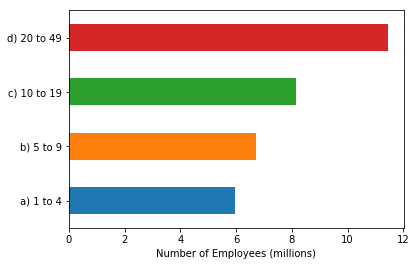

In [57]:
# plot 2013 as bar chart 
fig, ax = plt.subplots()
bdsp[2013].plot(ax=ax, kind='barh')
ax.set_ylabel('')
ax.set_xlabel('Number of Employees (millions)') 

<a id='review'></a>

## Review

We return to the OECD's healthcare data, specifically a subset of their table on the number of doctors per one thousand population.  This loads and cleans the data:  

In [58]:
url1 = 'http://www.oecd.org/health/health-systems/'
url2 = 'OECD-Health-Statistics-2017-Frequently-Requested-Data.xls'
docs = pd.read_excel(url1+url2, 
                     skiprows=3, 
                     usecols=[0, 51, 52, 53, 54, 55, 57],
                     sheetname='Physicians', 
                     na_values=['..'],
                     skip_footer=21) 
# rename country variable 
names = list(docs)
docs = docs.rename(columns={names[0]: 'Country'})
# strip footnote numbers from country names 
docs['Country'] = docs['Country'].str.rsplit(n=1).str.get(0)
docs = docs.head()
docs

/Users/wasserman/anaconda3/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Country,2009,2010,2011,2012,2013,2015
0,Australia,3.12,NaN,3.32,3.31,3.39,3.52
1,Austria,4.69,4.80,4.84,4.90,4.99,5.10
2,Belgium,2.92,2.92,2.91,2.93,2.95,3.02
3,Canada,2.34,2.38,2.46,2.51,2.57,2.66
4,Chile,NaN,1.43,1.58,1.74,1.87,2.14


Use this data to:  

* Set the index as `Country`.  
* Construct a horizontal bar chart of the number of doctors in each country in "2013 (or nearest year)".  
* Apply the `drop` method to `docs` to create a dataframe `new` that's missing the last column.  
* *Challenging.* Use `stack` and `unstack` to "pivot" the data so that columns are labeled by country names and rows are labeled by year.  This is challenging because we have left out the intermediate steps.  
* Plot the number of doctors over time in each country as a line in the same plot. 

*Comment.* In the last plot, the x axis labels are non-intuitive.  Ignore that.  

## Resources

Far and away the best material on this subject is Brandon Rhodes' 2015 Pycon presentation.  2 hours and 25 minutes and worth every second.  

* Video:  https://youtu.be/5JnMutdy6Fw
* Materials:  https://github.com/brandon-rhodes/pycon-pandas-tutorial
* Outline:  https://github.com/brandon-rhodes/pycon-pandas-tutorial/blob/master/script.txt

In [ ]:
#